In [67]:
import os
import cv2
import numpy as np
import math
import time
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook
from scipy import interpolate

In [101]:
NUM_IMAGES=1
filename = "glass2_test_40Deg_lightOblique.tiff"
file_location = "../FLIR_Camera"

In [102]:
def quad_algo(image_data):
    '''
    Extract image data from each of the 4 polarized quadrants
    '''
    tic = time.time()

    im90 = image_data[0::2, 0::2]
    im45 = image_data[0::2, 1::2]
    im135 = image_data[1::2, 0::2]
    im0 = image_data[1::2, 1::2]

    toc = time.time()
    print("Quad algorithm time ", toc - tic, "s")
    
    return im90, im45, im135, im0

In [103]:
def write_quad_image(quad_image, quad_angle, location):
    cv2.imwrite(os.path.join(location, filename+"_"+"IM{}-{}.tiff".format(quad_angle,i)), quad_image)

In [104]:
def write_glare_reduced_image(im90, im45, im135, im0, location):
    '''
    Calculate a glare reduced image by taking the lowest pixel value from each quadrant
    '''
    tic = time.time()

    glare_reduced_image = np.minimum.reduce([im90, im45, im135, im0])

    toc = time.time()
    print("Glare reduction time: ", toc - tic, "s")

    cv2.imwrite(os.path.join(location, filename+"_"+"GlareReduced-{}.tiff".format(i)), glare_reduced_image)
    
    return glare_reduced_image 

In [105]:
def calculate_Stokes_Params(im90, im45, im135, im0):
    '''
    Calculate Stokes parameters
    '''
    tic = time.time()

    im_stokes0 = im0.astype(np.float) + im90.astype(np.float)
    im_stokes1 = im0.astype(np.float) - im90.astype(np.float)
    im_stokes2 = im45.astype(np.float) - im135.astype(np.float)

    toc = time.time()
    print("Stokes time: ", toc - tic, "s")
    
    return im_stokes0, im_stokes1, im_stokes2

In [106]:
    
def calculate_DOLP(im_stokes0, im_stokes1, im_stokes2):
    '''
    Calculate DoLP
    '''
    tic = time.time()

    im_DOLP = np.divide(
        np.sqrt(np.square(im_stokes1) + np.square(im_stokes2)),
        im_stokes0,
        out=np.zeros_like(im_stokes0),
        where=im_stokes0 != 0.0,
    ).astype(np.float)

    im_DOLP = np.clip(im_DOLP, 0.0, 1.0)
    toc = time.time()
    print("DoLP time: ", toc - tic, "s")
    
    return im_DOLP

In [107]:
def normalise_DOLP(im_DOLP):
    '''
    Normalize from [0.0, 1.0] range to [0, 255] range (8 bit)
    '''
    im_DOLP_normalized = (im_DOLP * 255).astype(np.uint8)
    return im_DOLP_normalized

In [108]:
def DOLP_curve(ni, nt):
    '''
    Get the theoretical DOLP curve for unpolarized light transmission 
    from incident medium with refractive index ni to the transmission medium
    of refractive index nt
    '''
    #nt: 1.47 borosilicate glass; %1.58; %(ferrofluid emg 905);%1.333; 57.68 for EMG 905
    
    th_Brewster = np.arctan2(nt,ni)
    
    thI = np.linspace(0, th_Brewster, 200).astype(
        np.float
    )
    thT = np.arcsin(ni*np.sin(thI)/nt).astype(
        np.float
    )

    alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
    eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2

    DOLP = np.abs((alpha - eta)/(alpha + eta))
    
    fig = plt.figure(figsize=(5, 5),  facecolor='w', edgecolor='k')
    plt.plot(thI*180/np.pi, np.abs(DOLP),color='Indigo', linestyle='--', linewidth=3)
    plt.axvline(x=th_Brewster*180/np.pi, linestyle='-', linewidth=3)
    plt.xlabel("Incidence angle ($\\theta_i$) [deg]", fontsize=16)
    plt.ylabel("DOLP($\\theta_i$)", fontsize = 16)
    plt.xlim(0,90)
    plt.grid()
    plt.show()
    
    return DOLP, thI

In [109]:
def DOLP2Theta(ni, nt, im_DOLP):
    '''
    Convert from measured DOLP to theta using theoretical interpolation
    '''
    theoretical_DOLP_curve, theta_in_radians = DOLP_curve(ni, nt)

    f = interpolate.interp1d(theoretical_DOLP_curve, theta_in_radians*180/np.pi)
    im_theta = np.zeros_like(im_DOLP)
    
    DOLP_errors = []
    tic = time.time()
    for i in range(im_theta.shape[0]):
        for j in range(im_theta.shape[1]):
            try:
                im_theta[i,j] = f(im_DOLP[i,j])
            except ValueError:
                DOLP_errors.append(im_DOLP[i,j])
    
    toc = time.time()
    print("Time for DOLP2Theta conversion is : ", toc-tic, "seconds")
    return im_theta, DOLP_errors

In [110]:
def write_image(im_prefix, im_number, image, location):
    cv2.imwrite(os.path.join(location, filename+"_"+"{}-{}.tiff".format(im_prefix, im_number)), image)

In [111]:
def heatmap_from_greyscale(grey_image):
    '''
    @ param: grey_image : [0, 255] range (8 bit) image array
    '''
    # Create a heatmap from the greyscale image
    im_heatmap = cv2.applyColorMap(
        grey_image, cv2.COLORMAP_JET
    )
    return im_heatmap

In [112]:
def calculate_AOLP(im_stokes1, im_stokes2):
    '''
    Calculate AoLP
    '''
    tic = time.time()

    im_AOLP = (0.5 * np.arctan2(im_stokes2, im_stokes1)).astype(
        np.float
    )
    toc = time.time()
    print("AoLP time: ", toc - tic, "s")
    return im_AOLP

In [113]:
def normalise_AOLP(im_AOLP):
    '''
    Normalize from [-pi/2, pi/2] range to [0, 255] range (8 bit)
    '''
    im_AOLP_normalized = (
        (im_AOLP + math.pi / 2) * (255 / math.pi)
    ).astype(np.uint8)
    return im_AOLP_normalized

In [114]:
def saveplot(location, filename, suffix):
    plt.savefig(os.path.join(location, filename+"_"+"{}.png".format(suffix)))

image_data shape is :  (2048, 2448)
Quad algorithm time  0.0 s
im90 shape is :  (1024, 1224)
Stokes time:  0.0419764518737793 s
DoLP time:  0.03298068046569824 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


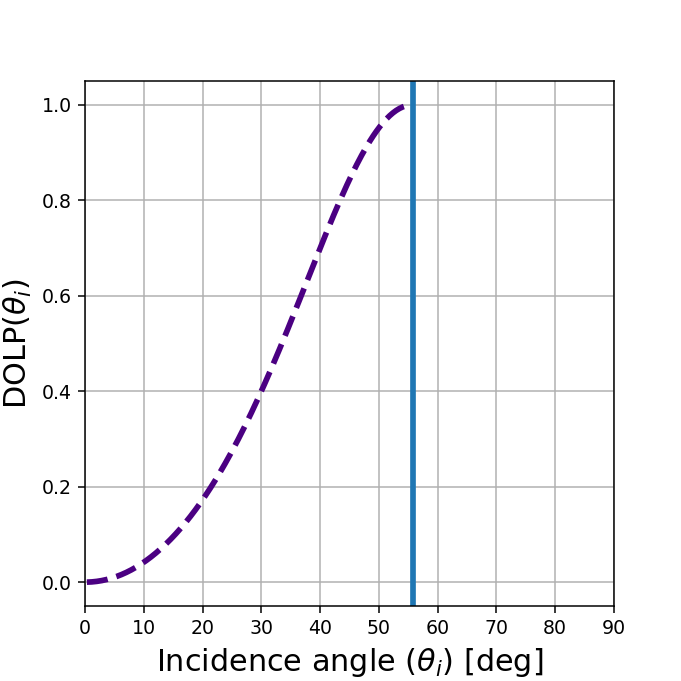

Time for DOLP2Theta conversion is :  24.556986093521118 seconds
False
AoLP time:  0.06096506118774414 s


In [115]:
for i in range(NUM_IMAGES):
    image_data = cv2.imread(os.path.join(file_location, filename).format(i))[:,:,0]
    print("image_data shape is : ", image_data.shape)
#     print(not (image_data[:,:,0]==image_data[:,:,2]).all())
    im90, im45, im135, im0 = quad_algo(image_data)
    print("im90 shape is : ", im90.shape)
    
    write_quad_image(im90, 90, file_location)
    write_quad_image(im90, 45, file_location)
    write_quad_image(im90, 135, file_location)
    write_quad_image(im90, 0, file_location)
    
    # Get Stokes vector first 3 components from 4 quad images
    im_stokes0, im_stokes1, im_stokes2 = calculate_Stokes_Params(im90, im45, im135, im0)
    
    # Get DOLP from Stokes measurements
    im_DOLP = calculate_DOLP(im_stokes0, im_stokes1, im_stokes2)
    
    # Get theta (Angle of incidence) from DOLP
    im_theta, DOLP_errors =  DOLP2Theta(1, 1.47, im_DOLP)
    print(np.array(DOLP_errors).any())
    
    # Create a heatmap from the greyscale image
    im_DOLP_normalized = normalise_DOLP(im_DOLP)    
    im_DOLP_heatmap = heatmap_from_greyscale(im_DOLP_normalized)
    write_image("DOLP_heatmap", i, im_DOLP_heatmap, file_location)
    
    # Get AOLP from Stokes measurements
    im_AOLP = calculate_AOLP(im_stokes1, im_stokes2)
    
    # Get angle of plane of polarization from AOLP
    im_phi = (im_AOLP + np.pi/2)*180/np.pi;
    
    # Create a heatmap from the greyscale image
    im_AOLP_normalized = normalise_AOLP(im_AOLP)    
    im_AOLP_heatmap = heatmap_from_greyscale(im_AOLP_normalized)
    write_image("AOLP_heatmap", i, im_AOLP_heatmap, file_location)    

<IPython.core.display.Javascript object>


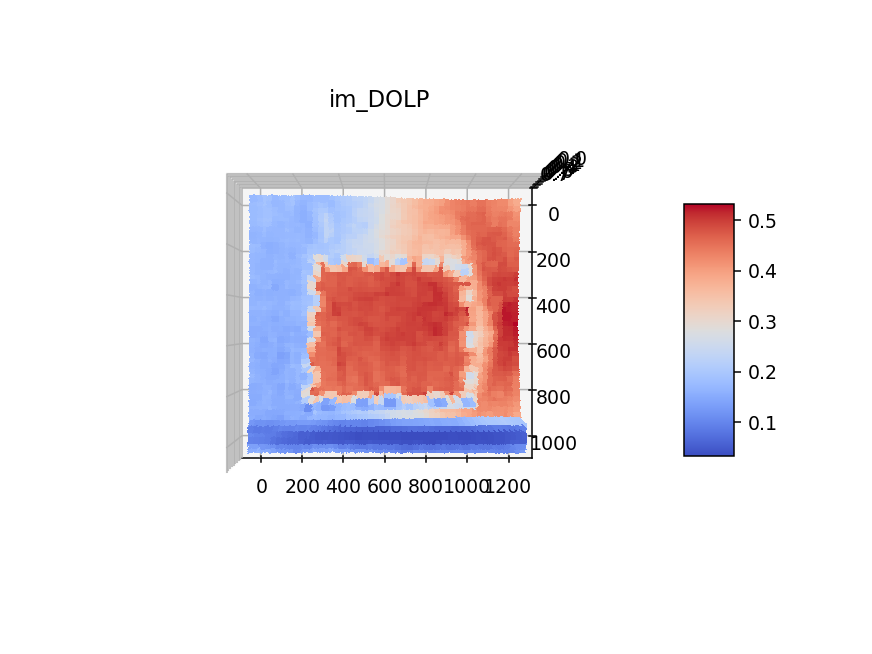

In [116]:
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')

r, c = im_DOLP.shape[0], im_DOLP.shape[1]
X, Y = np.meshgrid(np.arange(c), np.arange(r))
Z = im_DOLP
# apply Gauss filter if you want to get rid of the noise in the output

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))

ax.view_init(azim=-90, elev = -90)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('im_DOLP')
plt.show()

(1024, 1224)


<IPython.core.display.Javascript object>


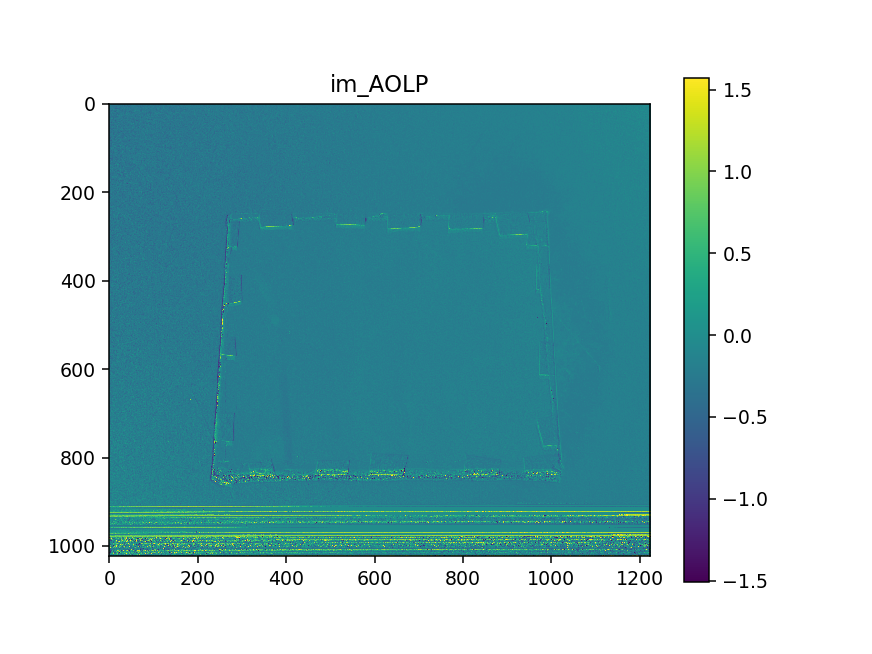

In [117]:
%matplotlib notebook
print(im_AOLP.shape)
plt.imshow(im_AOLP)
plt.title('im_AOLP')
plt.colorbar()

<IPython.core.display.Javascript object>


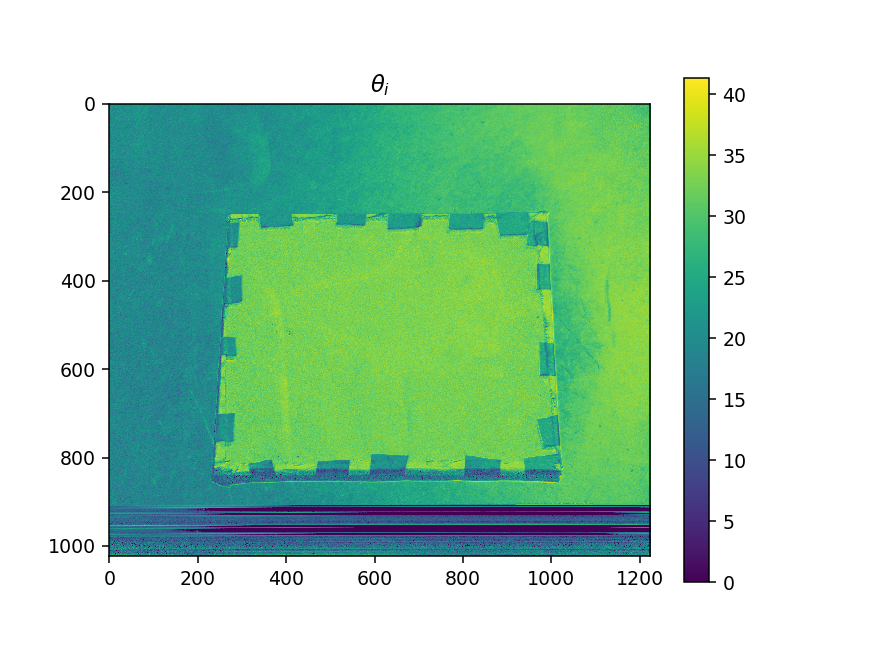

In [118]:
%matplotlib notebook
plt.imshow(im_theta)
plt.title('$\\theta_i$')
plt.colorbar()
saveplot(file_location , filename[:-5], "AOI")

In [89]:
im_theta

array([[33.93371286, 33.72534025, 33.87287022, ..., 25.43854668,
        25.0077262 , 24.85423832],
       [33.91272043, 33.72561631, 32.22938406, ..., 24.48546637,
        26.2708671 , 26.79979447],
       [33.65725603, 34.09580052, 34.44025618, ..., 25.0077262 ,
        27.36255284, 26.76272815],
       ...,
       [31.83901635, 19.09897845, 17.09211794, ..., 22.01237715,
        12.17484619, 22.01237715],
       [21.46019362, 31.83901635,  0.        , ..., 13.48302358,
        19.65127131, 19.65127131],
       [22.6462846 , 14.63262056, 24.91926289, ..., 19.09897845,
        21.46019362, 14.63262056]])

<IPython.core.display.Javascript object>


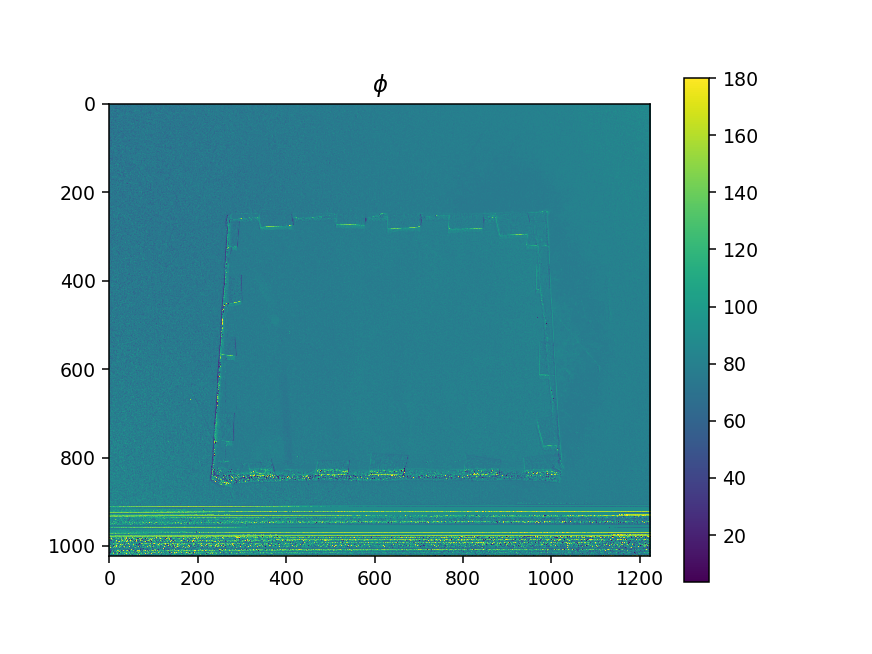

In [119]:
%matplotlib notebook
plt.imshow(im_phi)
plt.title('$\\phi$')
plt.colorbar()
saveplot(file_location , filename[:-5], "ProjSurfAngle")

- **Changing AO projection plane for changing illumination orientation:** When light is headon in line with the camera, the angle of plane of polarization is what is expected -- ~ 90 degrees. On the other hand if the light illuminating the surface is oblique, then the angle is different, about 80 degrees for the chosen oblique orientation of the lamp. 
- **Constant AOI with changing orientation:** But the Angle of incidence if found to be near constant 32-35 degrees for oblique and headon illumination. Value does not make a whole lot of sense as the incidence angle is fixed to be 40 degrees. But the constancy idea makes sense. Calibration can be done to check what orientation the computer is seeing